In [1]:
# 베이스 추정에 의한 회귀 분석
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# 트레이닝 셋 {x_n,y_n} (n=1...N) 을 준비
def generate_training_set(num):
    dataset = pd.DataFrame(columns=["x", "y"])
    for idx in range(num):
        x = float(idx) / float(num - 1)
        y = np.sin(2.0 * np.pi * x) + np.random.normal(scale=0.3)
        dataset = dataset.append(pd.Series([x, y], index=["x", "y"]),
                                 ignore_index=True)
    return dataset

In [36]:
def calc_phi(dataset,M):
    phis = pd.DataFrame() # (size=(N,M+1))

    for i in range(0, m + 1):
        p = dataset.x ** i
        p.name = "x**%d" % i
        phis = pd.concat([phis, p], axis=1)
    return phis

In [37]:
def calc_s(phis):
    # 분산(S) 계산
    phiphi_sum = 0
    for _, phi in phis.iterrows():
        phi = phi.values[:,np.newaxis] # reshape the phi (M+1,) to (M+1,1)
        phiphi_sum += np.dot(phi,phi.T) # (size=(M+1,M+1))
    s_inv = alpha * pd.DataFrame(np.identity(m + 1)) + beta * phiphi_sum
    s = np.linalg.inv(s_inv)  # 사후분포의 공분산행렬
    return s

In [41]:
#phis (size=(5,10))
#tn (size = (5,)
# phis.iloc[0]*t.iloc[0]
M = 9
N = 100
training_set = generate_training_set(N)
t = training_set.y
phis = calc_phi(training_set,M)
s = calc_s(phis)
w_mean = (phis*t[:,np.newaxis]).sum(axis=0).values
df_p_w_t = pd.DataFrame({"mu": w_mean, "deviation": s.diagonal()})
df_p_w_t.index = ["w"+str(i) for i in range(M+1)]
df_p_w_t

<ipython-input-41-fa7757f26b67>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  w_mean = (phis*t[:,np.newaxis]).sum(axis=0).values


,mu,deviation
w0,6.699812,0.024860
w1,-12.455234,9.537684
w2,-13.882464,379.069209
w3,-12.168242,2721.281468
w4,-10.119849,5223.598348
w5,-8.325237,5690.096855
w6,-6.863092,6236.710804
w7,-5.693809,5827.905716
w8,-4.759123,6224.594886
w9,-4.007045,1579.354760


In [42]:
# 평균 m(x)
# phi.T: (size=(1,M+1))
# S: (size=(M+1,M+1))
# sigma_t_phi: (size=(M+1,1))
def mean_fun(x):
    t = training_set.y
    phi_x = np.array([x ** i for i in range(0, m + 1)])
    sigma_t_phi= np.sum(np.multiply(t.values[:,np.newaxis],phis.values),axis = 0)
    #TODO flatten지웠는데 괜찮을까?
    # m_x = np.linalg.multi_dot([beta*phi_x.T, s, sum]).flatten()
    m_x = np.linalg.multi_dot([beta*phi_x.T, s, sigma_t_phi]).flatten()
    return m_x

In [43]:
def deviation_fun(x):
    phi_x = pd.DataFrame([x ** i for i in range(0, m + 1)])
    variance = 1.0 / beta + np.linalg.multi_dot([phi_x.T, s, phi_x])
    # TODO diagonal()제거 했는데 괜찮을지 확인하기
    # return variance.diagonal()
    return np.sqrt(variance).diagonal()

In [44]:
def f(x,ws):
    # x : (size=(n,1))
    # ws : (size=(M+1))
    x_n = np.array([x ** i for i in range(0, m + 1)])
    return np.multiply(ws[:,np.newaxis],x_n).sum(axis = 0)

In [45]:
def draw_t_distribution(c,N):
    line_x = np.arange(0, 1.01, 0.01)
    line_y_true = np.sin(2 * np.pi * line_x)

    # 평균과 표준편차 곡선 계산
    line_y_mu = np.array(mean_fun(line_x))
    line_y_d = np.array(deviation_fun(line_x))

    # 그래프 이름 및 범위 설정
    axs[c][0].set_xlim(-0.05,1.05)
    axs[c][0].set_ylim(-2,2)
    axs[c][0].set_title("N=%d" % N)
    axs[c][0].scatter(training_set.x, training_set.y, marker='o', color='blue')
    # 실제값 표시
    axs[c][0].plot(line_x, line_y_true, color='green', linestyle=':')

    # 평균과 표준편차 곡선 표시
    axs[c][0].plot(line_x, line_y_mu, color='red', label='mean')
    axs[c][0].legend(loc=1)
    axs[c][0].plot(line_x, line_y_mu - line_y_d, color='black', linestyle='--')
    axs[c][0].plot(line_x, line_y_mu + line_y_d, color='black', linestyle='--')
def draw_ws(c,N,ws_samples):
    line_x = np.arange(0, 1.01, 0.01)
    line_y_mu = np.array(mean_fun(line_x))

    axs[c][1].set_xlim(-0.05,1.05)
    axs[c][1].set_ylim(-2,2)
    axs[c][1].set_title("N=%d" % N)
    axs[c][1].scatter(training_set.x, training_set.y, marker='o', color='blue')
    # 평균 곡선 표시
    axs[c][1].plot(line_x, line_y_mu, color='red', label="mean")
    axs[c][1].legend(loc=1)
    for index, ws in ws_samples.iterrows():
        line_y_f = f(line_x, ws)
        axs[c][1].plot(line_x, line_y_f, color='green', linestyle='--')

In [46]:
#파라미터 설정
beta_true = 1.0 / (0.3) ** 2
alpha = 1.0 / 100 ** 2
M = 9  # 다항식 차수
N_list = [4, 5, 10, 100]
beta = beta_true

<ipython-input-43-5c6b31197e58>:6: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(variance).diagonal()
<ipython-input-44-8f20ec19d644>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.multiply(ws[:,np.newaxis],x_n).sum(axis = 0)
<ipython-input-44-8f20ec19d644>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.multiply(ws[:,np.newaxis],x_n).sum(axis = 0)
<ipython-input-44-8f20ec19d644>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.multiply(ws[:,np.newaxis],x_n).sum(axis = 0)
<ipython-input-44-8f20ec19d644>:5: FutureWarning: Suppo

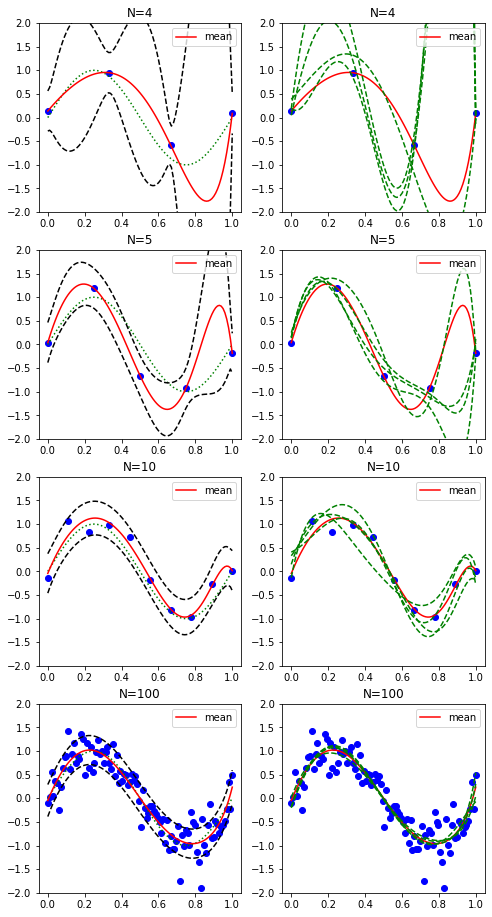

In [47]:
fig, axs = plt.subplots(len(N_list),2, figsize=(8,len(N_list)*4))
for c, N in enumerate(N_list):
    training_set = generate_training_set(N)
    t = training_set.y

    phis = calc_phi(training_set,M)
    sigma_t_phi= np.sum(np.multiply(t.values[:,np.newaxis],phis.values),axis = 0)
    s = calc_s(phis)

    mean = np.linalg.multi_dot([beta*s,sigma_t_phi])
    ws_samples = pd.DataFrame(np.random.multivariate_normal(mean,s,4))
    draw_t_distribution(c,N)
    draw_ws(c,N,ws_samples)
fig.show()